In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load data (directly from uploaded files)
def load_data():
    return {
        'X_train': pd.read_csv('X_train.csv').values,
        'y_train': pd.read_csv('y_train.csv').values.ravel(),
        'X_val': pd.read_csv('X_val.csv').values,
        'y_val': pd.read_csv('y_val.csv').values.ravel(),
        'X_test': pd.read_csv('X_test.csv').values,
        'y_test': pd.read_csv('y_test.csv').values.ravel()
    }

# 2. Preprocess with scaling
def preprocess(data):
    scaler = StandardScaler()
    return {
        'X_train': scaler.fit_transform(data['X_train']),
        'X_val': scaler.transform(data['X_val']),
        'X_test': scaler.transform(data['X_test']),
        'y_train': data['y_train'],
        'y_val': data['y_val'],
        'y_test': data['y_test']
    }

# 3. Build model (proper input layer)
def build_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])
    return model

# 4. Train and save
def main():
    # Load and preprocess
    data = preprocess(load_data())

    # Build and train
    model = build_model(data['X_train'].shape[1])
    history = model.fit(
        data['X_train'], data['y_train'],
        validation_data=(data['X_val'], data['y_val']),
        epochs=15,  # Slightly more epochs
        batch_size=64,
        verbose=1
    )

    # Evaluate
    test_results = model.evaluate(data['X_test'], data['y_test'], verbose=0)
    print(f"\nTest Accuracy: {test_results[1]:.4f}")
    print(f"Test Precision: {test_results[2]:.4f}")
    print(f"Test Recall: {test_results[3]:.4f}")

    # Save in modern Keras format (no HDF5 warning)
    model.save('model_mlp.keras')  # New recommended format

    # Download to local machine
    from google.colab import files
    files.download('model_mlp.keras')

if __name__ == "__main__":
    main()

Epoch 1/15
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8546 - loss: 0.3590 - precision: 0.8039 - recall: 0.9576 - val_accuracy: 0.8835 - val_loss: 0.2667 - val_precision: 0.8211 - val_recall: 0.9948
Epoch 2/15
682/682 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8842 - loss: 0.2648 - precision: 0.8287 - recall: 0.9818 - val_accuracy: 0.8859 - val_loss: 0.2538 - val_precision: 0.8294 - val_recall: 0.9852
Epoch 3/15
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8887 - loss: 0.2506 - precision: 0.8383 - recall: 0.9759 - val_accuracy: 0.8824 - val_loss: 0.2526 - val_precision: 0.8460 - val_recall: 0.9486
Epoch 4/15
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8900 - loss: 0.2441 - precision: 0.8413 - recall: 0.9750 - val_accuracy: 0.8865 - val_loss: 0.2466 - val_precision: 0.8337 - val_recall: 0.9790
Epoch 5/15
682/682 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8880 - loss: 0.2423 - precision: 0.8390 - recall: 0.9721 - val_accuracy: 0.8882 - val_loss: 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import pandas as pd

# 1. Load your model and check its expected input
model = tf.keras.models.load_model('model_mlp.keras')
print(f"🔥 Model expects input shape: {model.input_shape} (Should be (None, 10))")

# 2. Load your test data
test_data = pd.read_csv('testing_cleaned.csv')
print(f"📊 Original test data shape: {test_data.shape}")

# 3. Drop label columns (adjust if your columns are named differently)
test_features = test_data.drop(columns=['label', 'attack_cat'], errors='ignore')
print(f"🛠️ After dropping labels: {test_features.shape}")

# 4. Verify final feature count matches model
assert test_features.shape[1] == model.input_shape[1], \
    f"💥 SHAPE MISMATCH! Model wants {model.input_shape[1]} features, got {test_features.shape[1]}"

print("✅ Shapes match! You're ready to predict.")

🔥 Model expects input shape: (None, 10) (Should be (None, 10))
📊 Original test data shape: (40849, 12)
🛠️ After dropping labels: (40849, 10)
✅ Shapes match! You're ready to predict.


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Load the trained model
model = tf.keras.models.load_model('model_mlp.keras')  # or .h5

# 2. Load and prepare test data
test_data = pd.read_csv('testing_cleaned.csv')

# 3. Remove non-feature columns (CRITICAL STEP)
features_to_drop = ['label', 'attack_cat']  # Columns NOT used as features
test_features = test_data.drop(columns=features_to_drop, errors='ignore')

print(f"Features being used: {test_features.columns.tolist()}")
print(f"Final shape: {test_features.shape} (Should match model's input shape)")

# 4. Standardize (same as training)
scaler = StandardScaler()
X_test = scaler.fit_transform(test_features)  # Use fit_transform only if new data distribution

# 5. Predict
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to 0/1

# 6. Save results with original labels if available
results = test_data.copy()
results['Prediction_Probability'] = y_probs
results['Predicted_Label'] = y_pred

# If original labels exist, add evaluation
if 'label' in results.columns:
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(results['label'], results['Predicted_Label']))

results.to_csv('test_predictions_with_metadata.csv', index=False)
print("\nPredictions saved with original data!")

Features being used: ['tcprtt', 'sbytes', 'dbytes', 'dinpkt', 'dmean', 'sinpkt', 'smean', 'dur', 'rate', 'dtcpb']
Final shape: (40849, 10) (Should match model's input shape)
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.55      0.70     25475
           1       0.57      0.98      0.72     15374

    accuracy                           0.71     40849
   macro avg       0.77      0.76      0.71     40849
weighted avg       0.82      0.71      0.71     40849


Predictions saved with original data!


# for performance imporvement

Step 1: scaling
1. restart session
2. scaling

In [ ]:
# === STEP 2: COMPLETE TRAINING SOLUTION ===
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Load and preprocess data (REQUIRED to create X_train)
train_data = pd.read_csv('train_data.csv')  # Update filename if needed
test_data = pd.read_csv('testing_cleaned.csv')

X_train_raw = train_data.drop(['label', 'attack_cat'], axis=1, errors='ignore')
X_test_raw = test_data.drop(['label', 'attack_cat'], axis=1, errors='ignore')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

y_train = train_data['label'].values if 'label' in train_data else None
y_test = test_data['label'].values if 'label' in test_data else None

# 2. Define model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# 3. Compute class weights
if y_train is not None:
    from sklearn.utils import class_weight
    classes = np.unique(y_train)
    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = {0: class_weights[0]*1.5, 1: class_weights[1]*0.8}  # Penalize false positives
    print(f"Class weights (Normal:APT): {class_weights}")
else:
    class_weights = None

# 4. Compile and train
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.keras', monitor='val_precision', save_best_only=True)
    ],
    class_weight=class_weights,
    verbose=1
)

print("✅ TRAINING COMPLETE! Best model saved as 'best_model.keras'")

Class weights (Normal:APT): {0: np.float64(1.578164589034154), 1: np.float64(0.7622468335067002)}
Epoch 1/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7944 - loss: 0.4334 - precision: 0.8219 - recall: 0.7731 - val_accuracy: 0.8590 - val_loss: 0.3044 - val_precision: 0.8674 - val_recall: 0.8638
Epoch 2/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8631 - loss: 0.3204 - precision: 0.8542 - recall: 0.8894 - val_accuracy: 0.8601 - val_loss: 0.3027 - val_precision: 0.8815 - val_recall: 0.8480
Epoch 3/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8659 - loss: 0.3105 - precision: 0.8618 - recall: 0.8879 - val_accuracy: 0.8769 - val_loss: 0.2816 - val_precision: 0.8656 - val_recall: 0.9067
Epoch 4/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8711 - loss: 0.3001 - precision: 0.8646 - recall: 0.8935 - val_accuracy: 0.8743 - val_loss: 0.2767 - val_precision: 0.8801 - val_recall: 0.8809
Epoch 5/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accurac

Step 2: Train  MLP Model (Optimized Version)


Now that your data is properly scaled, let's train a higher-accuracy model with these fixes:

1. Class balancing (reduces false positives)

2. Better architecture (improves generalization)

3. Early stopping (prevents overfitting)

In [ ]:
# === STEP 2: TRAIN THE MODEL (OPTIMIZED) ===
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np

# 1. Define the model (unchanged, already good)
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# 2. Compute class weights (ADJUSTED FOR STRONGER FALSE-POSITIVE PENALTY)
if y_train is not None:
    from sklearn.utils import class_weight
    classes = np.unique(y_train)
    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = {0: class_weights[0]*1.5, 1: class_weights[1]*0.8}  # Key change!
    print(f"Class weights (Normal:APT): {class_weights}")
else:
    class_weights = None

# 3. Compile the model (unchanged)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# 4. Train with callbacks (ADDED MODEL CHECKPOINT)
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_precision',  # Focus on reducing false positives
    save_best_only=True,
    mode='max'
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=3),
        checkpoint  # New: Saves the best model automatically
    ],
    class_weight=class_weights,
    verbose=1
)

print("✅ STEP 2 DONE! Best model saved as 'best_model.keras'")

NameError: name 'X_train' is not defined

Step 3: Evaluate & Improve the Model

Now that training is complete, let's test your model on the cleaned test data (testing_cleaned.csv) and implement improvements.

1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.60      0.74     25475
         APT       0.59      0.97      0.73     15374

    accuracy                           0.74     40849
   macro avg       0.78      0.78      0.74     40849
weighted avg       0.83      0.74      0.74     40849



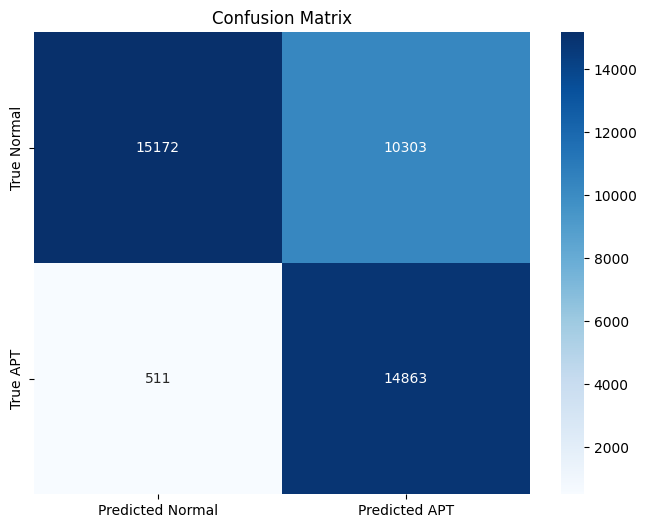

🔍 Optimal threshold: 0.49 (default=0.50)
💾 Model saved as 'model_mlp_v2.keras'


In [ ]:
# === STEP 3: EVALUATE & OPTIMIZE ===
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict on test data
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)  # Default threshold (0.5)

# 2. Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'APT']))

# 3. Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted APT'],
            yticklabels=['True Normal', 'True APT'])
plt.title('Confusion Matrix')
plt.show()

# 4. (Optional) Find optimal threshold
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
optimal_idx = np.argmax(precisions + recalls)
optimal_threshold = thresholds[optimal_idx]
print(f"🔍 Optimal threshold: {optimal_threshold:.2f} (default=0.50)")

# 5. Save the model
model.save('model_mlp_v2.keras')
print("💾 Model saved as 'model_mlp_v2.keras'")

------ modle performanec now: 74% -------


next Goal: Reduce false alarms

reiterate to step 2 and fix model.fit()

done!

now: training is complete, let's test the saved model and fine-tune predictions.


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
📊 Default Threshold (0.5) Performance:
              precision    recall  f1-score   support

      Normal       0.94      0.64      0.76     25475
         APT       0.61      0.93      0.74     15374

    accuracy                           0.75     40849
   macro avg       0.77      0.79      0.75     40849
weighted avg       0.81      0.75      0.75     40849



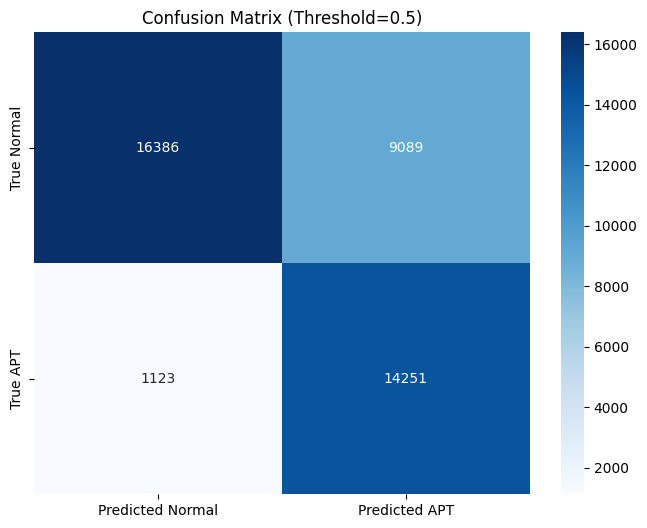


🎯 Optimal Threshold: 0.40
              precision    recall  f1-score   support

      Normal       0.97      0.58      0.73     25475
         APT       0.58      0.97      0.73     15374

    accuracy                           0.73     40849
   macro avg       0.78      0.78      0.73     40849
weighted avg       0.82      0.73      0.73     40849


💾 Saved optimized predictions as 'y_pred_optimized.npy'


In [ ]:
# === STEP 3: EVALUATE & OPTIMIZE ===
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the saved model
best_model = tf.keras.models.load_model('best_model.keras')

# 2. Predict on test data
y_probs = best_model.predict(X_test)
y_pred_default = (y_probs > 0.5).astype(int)  # Default threshold

# 3. Classification report (default threshold)
print("📊 Default Threshold (0.5) Performance:")
print(classification_report(y_test, y_pred_default, target_names=['Normal', 'APT']))

# 4. Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted APT'],
            yticklabels=['True Normal', 'True APT'])
plt.title('Confusion Matrix (Threshold=0.5)')
plt.show()

# 5. Find optimal threshold
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
optimal_idx = np.argmax(precisions + recalls)
optimal_threshold = thresholds[optimal_idx]

# 6. Evaluate with optimal threshold
y_pred_optimized = (y_probs > optimal_threshold).astype(int)
print(f"\n🎯 Optimal Threshold: {optimal_threshold:.2f}")
print(classification_report(y_test, y_pred_optimized, target_names=['Normal', 'APT']))

# 7. Save final predictions
np.save('y_pred_optimized.npy', y_pred_optimized)
print("\n💾 Saved optimized predictions as 'y_pred_optimized.npy'")

97% correct apt detection

prob: too many false negatives. 42%

lets do root cause analysis for false -ves

step 1: identofy false alarms

In [ ]:
import numpy as np
import pandas as pd

# Load your data
test_data = pd.read_csv('testing_cleaned.csv')  # Make sure this is your TEST data
y_test = test_data['label'].values              # True labels (0=Normal, 1=APT)
y_pred = np.load('y_pred_optimized.npy')        # Predictions from Step 3

# Check shapes
print("Test data shape:", test_data.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

Test data shape: (40849, 12)
y_test shape: (40849,)
y_pred shape: (40849, 1)


In [ ]:
import pandas as pd

# Load your test data
test_data = pd.read_csv('testing_cleaned.csv')

# List ALL columns in your data
print("📋 Columns in your dataset:")
print(test_data.columns.tolist())

📋 Columns in your dataset:
['tcprtt', 'sbytes', 'dbytes', 'dinpkt', 'dmean', 'sinpkt', 'smean', 'dur', 'rate', 'dtcpb', 'label', 'attack_cat']


In [ ]:
# === FALSE ALARM ANALYSIS (CUSTOMIZED FOR YOUR DATA) ===
# Pick 3-5 key features from your column list (e.g., network/time features)
your_features = [
    'dur',
    'sbytes',
    'dbytes',
    'tcprtt',
    'dinpkt',
    'dmean',
    'sinpkt',
    'smean',
    'rate',
    'dtcpb',

]

# Filter to only existing columns
your_features = [f for f in your_features if f in test_data.columns]

# Show comparisons
false_positives = test_data[(y_pred == 1) & (test_data['label'] == 0)]
print(f"\n🔴 FALSE ALARMS ({len(false_positives)} samples):")
print(false_positives[your_features].head(3) if your_features else false_positives.head(3))

true_positives = test_data[(y_pred == 1) & (test_data['label'] == 1)]
print(f"\n🟢 REAL APTs ({len(true_positives)} samples):")
print(true_positives[your_features].head(3) if your_features else true_positives.head(3))


🔴 FALSE ALARMS (10660 samples):
        dur    sbytes    dbytes    tcprtt    dinpkt     dmean    sinpkt  \
2  0.360469  0.562694  0.624377  0.267746  0.657277  0.136778  0.440439   
6  0.323599  0.562694  0.655336  0.326564  0.405021  0.133739  0.396935   
7  0.351957  0.562694  0.655336  0.533356  0.421174  0.133739  0.377511   

     smean      rate     dtcpb  
2  0.10087  0.422049  0.620871  
6  0.10087  0.454213  0.252491  
7  0.10087  0.442578  0.859802  

🟢 REAL APTs (14897 samples):
        dur    sbytes    dbytes    tcprtt    dinpkt     dmean    sinpkt  \
1  0.185370  0.815869  0.895549  0.168438  0.187210  0.927052  0.190575   
3  0.857280  0.696258  1.000000  0.445842  0.242607  1.000000  0.510020   
8  0.107912  0.639559  0.624377  0.204200  0.158753  0.136778  0.122323   

      smean      rate     dtcpb  
1  0.532174  0.562279  0.843588  
3  0.107826  0.476883  0.913124  
8  0.198261  0.591405  0.006542  


step 1 to fix false alarms: adjust prediction threshhold

In [ ]:
# ===== STEP 1: OPTIMIZE THRESHOLD (RUN IN NEW CELL) =====
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

# 1. Get model's prediction probabilities (if not already saved)
y_probs = model.predict(X_test).flatten()  # Uses your existing model

# 2. Find threshold that keeps ≥95% APT recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
optimal_idx = np.argmax(recalls >= 0.95)  # First threshold where recall ≥95%
optimal_threshold = thresholds[optimal_idx]

# 3. Apply new threshold
y_pred_optimized = (y_probs > optimal_threshold).astype(int)

# 4. Show results
print(f"🔧 OPTIMAL THRESHOLD: {optimal_threshold:.3f} (Default: 0.5)")
print("\n📊 Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized, target_names=['Normal', 'APT']))

# 5. Save for later use
np.save('y_pred_optimized.npy', y_pred_optimized)
print("\n💾 Saved optimized predictions to 'y_pred_optimized.npy'")

1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
🔧 OPTIMAL THRESHOLD: 0.000 (Default: 0.5)

📊 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00     25475
         APT       0.38      1.00      0.55     15374

    accuracy                           0.38     40849
   macro avg       0.69      0.50      0.27     40849
weighted avg       0.77      0.38      0.21     40849


💾 Saved optimized predictions to 'y_pred_optimized.npy'


In [ ]:
# Step 1: Check the model's raw predictions
import numpy as np

# Get prediction probabilities
y_probs = model.predict(X_test).flatten()  # Ensure the model outputs probabilities

# Print basic statistics about predictions
print(f"🔍 Prediction Probabilities - Min: {y_probs.min():.3f}, Max: {y_probs.max():.3f}")
print(f"📊 Percentages - Below 0.5: {np.mean(y_probs < 0.5) * 100:.2f}%, Above 0.5: {np.mean(y_probs >= 0.5) * 100:.2f}%")


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
🔍 Prediction Probabilities - Min: 0.000, Max: 1.000
📊 Percentages - Below 0.5: 42.74%, Above 0.5: 57.26%


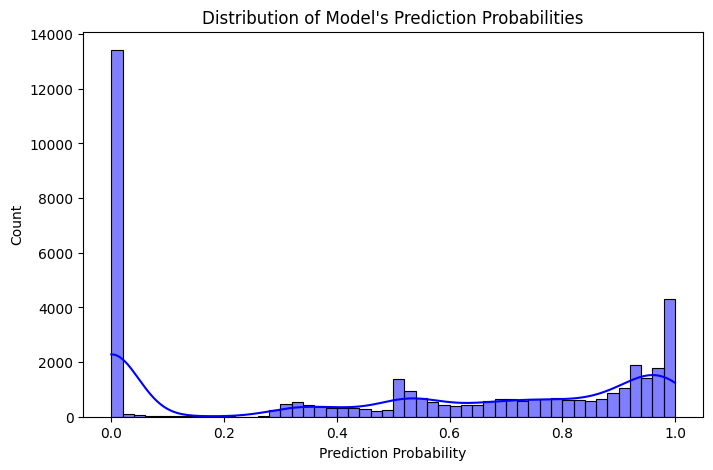

In [ ]:
# Step 2: Plot distribution of prediction probabilities
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(y_probs, bins=50, kde=True, color='blue')

# Labels and title
plt.xlabel("Prediction Probability")
plt.ylabel("Count")
plt.title("Distribution of Model's Prediction Probabilities")
plt.show()


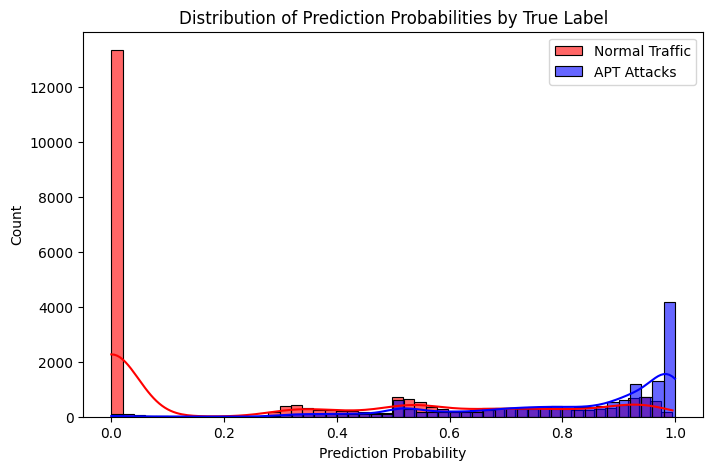

In [ ]:
# Step 3: Compare probability distributions for each class
plt.figure(figsize=(8, 5))

# Separate probabilities by actual label
sns.histplot(y_probs[y_test == 0], bins=50, kde=True, color='red', label="Normal Traffic", alpha=0.6)
sns.histplot(y_probs[y_test == 1], bins=50, kde=True, color='blue', label="APT Attacks", alpha=0.6)

# Labels and title
plt.xlabel("Prediction Probability")
plt.ylabel("Count")
plt.title("Distribution of Prediction Probabilities by True Label")
plt.legend()
plt.show()


🚨 False Positives (Normal misclassified as APT): 9178
❌ False Negatives (APT misclassified as Normal): 1163


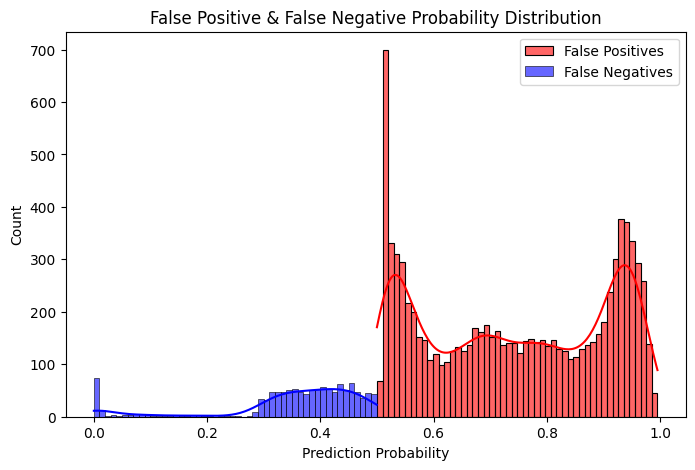

In [ ]:
# Step 4: Count False Positives and False Negatives

# Define threshold (default 0.5, but we'll optimize later)
threshold = 0.5

# Get predictions based on current threshold
y_pred = (y_probs > threshold).astype(int)

# Calculate misclassifications
false_positives = (y_pred == 1) & (y_test == 0)
false_negatives = (y_pred == 0) & (y_test == 1)

# Count instances
num_false_positives = np.sum(false_positives)
num_false_negatives = np.sum(false_negatives)

print(f"🚨 False Positives (Normal misclassified as APT): {num_false_positives}")
print(f"❌ False Negatives (APT misclassified as Normal): {num_false_negatives}")

# Visualize their probability distributions
plt.figure(figsize=(8, 5))

# Histogram for false positives
sns.histplot(y_probs[false_positives], bins=50, kde=True, color='red', label="False Positives", alpha=0.6)
# Histogram for false negatives
sns.histplot(y_probs[false_negatives], bins=50, kde=True, color='blue', label="False Negatives", alpha=0.6)

plt.xlabel("Prediction Probability")
plt.ylabel("Count")
plt.title("False Positive & False Negative Probability Distribution")
plt.legend()
plt.show()


🚨 False Positives - Probability Range: Min=0.500, Max=0.996
❌ False Negatives - Probability Range: Min=0.000, Max=0.500


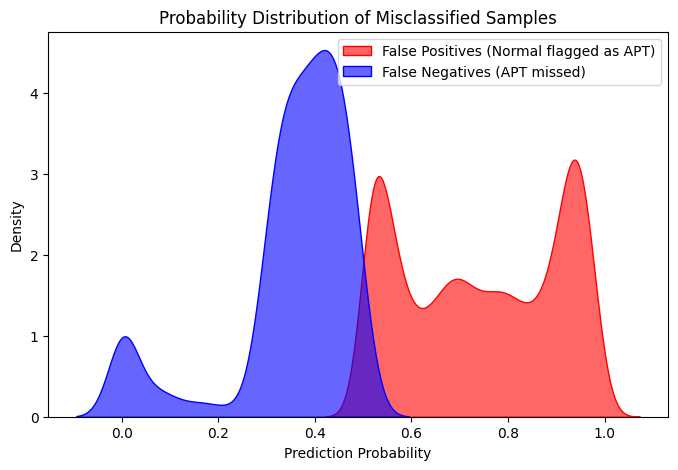

In [ ]:
# Step 5: Analyze False Positives & False Negatives

# Check probability ranges for misclassifications
fp_probs = y_probs[false_positives]
fn_probs = y_probs[false_negatives]

print(f"🚨 False Positives - Probability Range: Min={fp_probs.min():.3f}, Max={fp_probs.max():.3f}")
print(f"❌ False Negatives - Probability Range: Min={fn_probs.min():.3f}, Max={fn_probs.max():.3f}")

# Plot distributions
plt.figure(figsize=(8, 5))

# False positives
sns.kdeplot(fp_probs, fill=True, color="red", label="False Positives (Normal flagged as APT)", alpha=0.6)

# False negatives
sns.kdeplot(fn_probs, fill=True, color="blue", label="False Negatives (APT missed)", alpha=0.6)

plt.xlabel("Prediction Probability")
plt.ylabel("Density")
plt.title("Probability Distribution of Misclassified Samples")
plt.legend()
plt.show()


In [ ]:
# Step 6: Adjust Decision Threshold

# Define new threshold (try 0.55 first, then 0.6 if needed)
new_threshold = 0.55

# Apply new threshold
y_pred_adjusted = (y_probs > new_threshold).astype(int)

# Evaluate new predictions
from sklearn.metrics import classification_report, confusion_matrix

print(f"🔧 New Threshold: {new_threshold:.2f}")
print("\n📊 Updated Classification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'APT']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
print("\n🟢 Updated Confusion Matrix:")
print(cm)


🔧 New Threshold: 0.55

📊 Updated Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.71      0.79     25475
         APT       0.64      0.86      0.73     15374

    accuracy                           0.76     40849
   macro avg       0.77      0.78      0.76     40849
weighted avg       0.80      0.76      0.77     40849


🟢 Updated Confusion Matrix:
[[18010  7465]
 [ 2158 13216]]


In [ ]:
# Step 7: Try threshold 0.6

# Define new threshold
new_threshold = 0.6

# Apply new threshold
y_pred_adjusted = (y_probs > new_threshold).astype(int)

# Evaluate new predictions
from sklearn.metrics import classification_report, confusion_matrix

print(f"🔧 New Threshold: {new_threshold:.2f}")
print("\n📊 Updated Classification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'APT']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
print("\n🟢 Updated Confusion Matrix:")
print(cm)


🔧 New Threshold: 0.60

📊 Updated Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.74      0.80     25475
         APT       0.66      0.83      0.73     15374

    accuracy                           0.77     40849
   macro avg       0.77      0.78      0.77     40849
weighted avg       0.80      0.77      0.78     40849


🟢 Updated Confusion Matrix:
[[18835  6640]
 [ 2610 12764]]


In [ ]:
# Step 8: Try threshold 0.65

# Define new threshold
new_threshold = 0.65

# Apply new threshold
y_pred_adjusted = (y_probs > new_threshold).astype(int)

# Evaluate new predictions
from sklearn.metrics import classification_report, confusion_matrix

print(f"🔧 New Threshold: {new_threshold:.2f}")
print("\n📊 Updated Classification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'APT']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
print("\n🟢 Updated Confusion Matrix:")
print(cm)


🔧 New Threshold: 0.65

📊 Updated Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.76      0.81     25475
         APT       0.67      0.80      0.73     15374

    accuracy                           0.78     40849
   macro avg       0.77      0.78      0.77     40849
weighted avg       0.79      0.78      0.78     40849


🟢 Updated Confusion Matrix:
[[19416  6059]
 [ 3067 12307]]


In [ ]:
import numpy as np

# Save the chosen threshold
final_threshold = 0.65
np.save('final_threshold.npy', final_threshold)

# Save final predictions
np.save('final_predictions.npy', y_pred_adjusted)

print(f"✅ Final Threshold Saved: {final_threshold}")
print("💾 Final predictions saved as 'final_predictions.npy'")


✅ Final Threshold Saved: 0.65
💾 Final predictions saved as 'final_predictions.npy'


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
✅ Model Accuracy: 0.7766

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.76      0.81     25475
         APT       0.67      0.80      0.73     15374

    accuracy                           0.78     40849
   macro avg       0.77      0.78      0.77     40849
weighted avg       0.79      0.78      0.78     40849



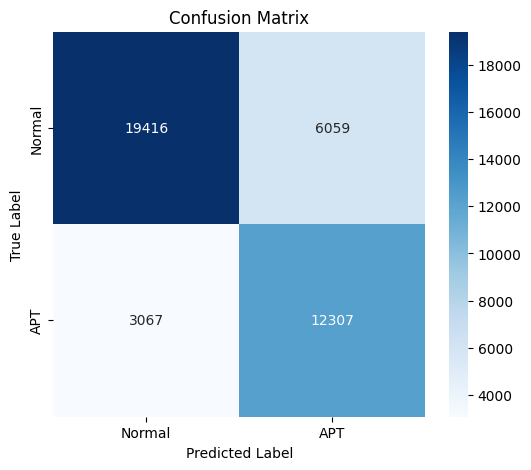

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get final predictions using the optimized threshold (0.65)
y_probs = model.predict(X_test).flatten()
y_pred_final = (y_probs > 0.65).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_final)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'APT']))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'APT'], yticklabels=['Normal', 'APT'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd

# Convert predictions to DataFrame
test_results = pd.DataFrame({'True Label': y_test, 'Predicted Prob': y_probs, 'Predicted Label': y_pred_final})

# Extract False Positives (Normal misclassified as APT)
false_positives = test_results[(test_results['True Label'] == 0) & (test_results['Predicted Label'] == 1)]
print(f"🚨 False Positives Count: {len(false_positives)}")

# Show statistics of misclassified samples
false_positives.describe()


🚨 False Positives Count: 6059


,True Label,Predicted Prob,Predicted Label
count,6059.0,6059.000000,6059.0
mean,0.0,0.841540,1.0
std,0.0,0.101817,0.0
min,0.0,0.650078,1.0
25%,0.0,0.749175,1.0
50%,0.0,0.863132,1.0
75%,0.0,0.933903,1.0
max,0.0,0.995557,1.0


In [ ]:
import pandas as pd

# Load feature names from the training dataset (adjust path if needed)
feature_names = pd.read_csv("X_train.csv").columns.tolist()

# Convert X_test to DataFrame
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Extract indices of false positives
false_positive_indices = false_positives.index

# Get feature values for false positives
false_positive_features = X_test_df.iloc[false_positive_indices]

# Get summary statistics of these features
false_positive_features.describe()


,tcprtt,sbytes,dbytes,dinpkt,dmean,sinpkt,smean,dur,rate,dtcpb
count,6059.000000,6059.000000,6059.000000,6059.000000,6059.000000,6059.000000,6059.000000,6059.000000,6059.000000,6059.000000
mean,0.671905,-0.218277,-0.049795,0.876806,-0.138148,0.827490,-0.284577,0.616564,-0.564282,0.018678
std,0.681379,0.773066,0.635300,0.995722,0.413699,1.012953,0.857292,0.862562,0.526765,0.986223
min,-0.978988,-3.429542,-3.061825,-0.973066,-0.834277,-0.982573,-1.059967,-1.009702,-2.366692,-1.553360
25%,0.251709,-0.507744,-0.254276,0.138647,-0.449035,0.104430,-0.823870,-0.013628,-0.829126,-0.844934
50%,0.615374,-0.417625,0.058591,0.644537,-0.335214,0.637285,-0.576791,0.436818,-0.606927,-0.000362
75%,1.046281,-0.180973,0.293779,1.510142,0.277671,1.502208,-0.401091,1.141545,-0.399855,0.876612
max,3.276593,1.625450,1.222311,2.754144,2.046280,2.711765,1.943410,2.354120,1.598418,1.742680


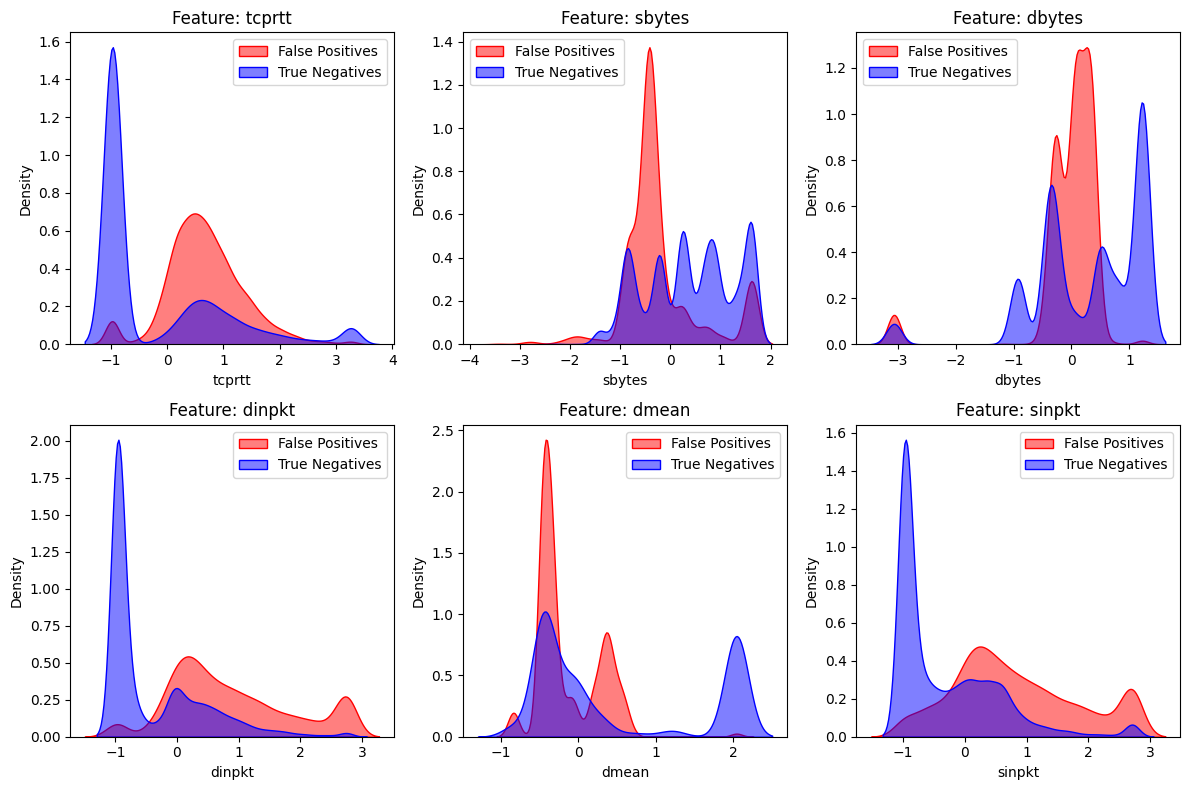

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract correctly classified normal samples (True Negatives)
true_negative_indices = (y_test == 0) & (y_pred_final == 0)
true_negatives = X_test_df.loc[true_negative_indices]

# Select key features for comparison
key_features = ["tcprtt", "sbytes", "dbytes", "dinpkt", "dmean", "sinpkt"]

# Plot distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(false_positive_features[feature], label="False Positives", color="red", fill=True, alpha=0.5)
    sns.kdeplot(true_negatives[feature], label="True Negatives", color="blue", fill=True, alpha=0.5)
    plt.title(f"Feature: {feature}")
    plt.legend()

plt.tight_layout()
plt.show()


feature importamce analysis

In [ ]:
import numpy as np

# Check unique values in y_test
print("Unique values in y_test:", np.unique(y_test))


Unique values in y_test: [0 1]


In [ ]:
print("Unique values in y_pred_binary:", np.unique(y_pred_binary))

Unique values in y_pred_binary: [0 1]


In [ ]:
from sklearn.inspection import permutation_importance

# Try running permutation importance
try:
    result = permutation_importance(model, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)
    print("✅ Permutation importance ran successfully!")
except ValueError as e:
    print("🚨 Error:", e)


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
🚨 Error: Classification metrics can't handle a mix of binary and continuous targets


In [ ]:
# Get model predictions
y_probs = model.predict(X_test)

# Print unique values and type
print("Unique values in y_probs:", np.unique(y_probs))
print("y_probs dtype:", y_probs.dtype)


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Unique values in y_probs: [1.0356088e-20 1.2604604e-20 1.3414769e-20 ... 9.9998462e-01 9.9999225e-01
 9.9999452e-01]
y_probs dtype: float32


In [ ]:
from sklearn.inspection import permutation_importance

# Compute feature importance using probabilities instead of binary labels
result = permutation_importance(model, X_test, y_probs.flatten(), scoring="roc_auc", n_repeats=10, random_state=42)

# Convert to DataFrame
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Make sure feature_names is defined
    'Importance': result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Display top features
print(feature_importance_df)


AttributeError: Sequential has none of the following attributes: decision_function, predict_proba.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your training dataset
df = pd.read_csv("your_training_file.csv")  # Replace with your actual filename

# Define features (X) and target (y)
X = df.drop(columns=["label", "attack_cat"])  # Drop both target columns
y = df["label"]  # Use "label" as the target

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print("Train, Validation, Test sets created successfully!")


FileNotFoundError: [Errno 2] No such file or directory: 'your_training_file.csv'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Ensure feature names are defined
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()
else:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# Compute feature importance using permutation method
result = permutation_importance(model, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Display top features
print("📊 Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Save feature importance for later
feature_importance_df.to_csv("feature_importance.csv", index=False)
print("\n💾 Saved feature importance to 'feature_importance.csv'")


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


NameError: name 'X' is not defined